# Dynamic Pricing of Electronic Products

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings("ignore")

# Reading dataset

In [2]:
# import dataset
products = pd.read_csv('/Users/revathysurendran/Documents/Dissertation/DatafinitiElectronicsProductsPricingData.csv')
print('product data:\n',products)
print("Dataset Shape: ", products.shape)
print('\n',products.isnull().sum())
print(products.info())

product data:
                         id  prices.amountMax  prices.amountMin  \
0     AVphzgbJLJeJML43fA0o            104.99            104.99   
1     AVpgMuGwLJeJML43KY_c             69.00             64.99   
2     AVpgMuGwLJeJML43KY_c             69.00             69.00   
3     AVpgMuGwLJeJML43KY_c             69.99             69.99   
4     AVpgMuGwLJeJML43KY_c             66.99             66.99   
...                    ...               ...               ...   
7244  AVpfUsrxLJeJML437Ezd             79.99             79.99   
7245  AVpfUsrxLJeJML437Ezd             68.75             68.75   
7246  AVpfUsrxLJeJML437Ezd             70.99             70.99   
7247  AVpfUsrxLJeJML437Ezd             71.99             71.99   
7248  AVpfUsrxLJeJML437Ezd             67.77             67.77   

     prices.availability prices.condition prices.currency  \
0                    Yes              New             USD   
1               In Stock              New             USD   
2        

# Data Preprocessing

In [3]:
def data_preprocessing_pipeline(data):
    #Remove manufacturer column as it is same as brand column.
    data = data.drop(['manufacturer'], axis=1)
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int', 'bool']).columns
    categorical_features = data.select_dtypes(include=['object']).columns
    
    #Handle missing values in categorical features 
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])
    le = LabelEncoder()
    data['prices.availability'] = le.fit_transform(data['prices.availability'])
    data['prices.condition'] = le.fit_transform(data['prices.condition'])
    data['prices.currency'] = le.fit_transform(data['prices.currency'])
    data['prices.merchant'] = le.fit_transform(data['prices.merchant'])
    data['prices.shipping'] = le.fit_transform(data['prices.shipping'])
    data['brand'] = le.fit_transform(data['brand'])
    data['name'] = le.fit_transform(data['name'])
    data['primaryCategories'] = le.fit_transform(data['primaryCategories'])
    data['dateAdded'] = pd.to_datetime(data['dateAdded'])
    data['dateAdded'] = data['dateAdded'].apply(lambda x: x.timestamp())

    
    #Standardization of dependent variables
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[numeric_features])
    data[numeric_features] = scaler.transform(data[numeric_features])
    
    return data

In [4]:
#Perform data preprocessing
products_new = products[['prices.amountMax','prices.amountMin','prices.availability','prices.condition','prices.currency','prices.isSale','prices.merchant','prices.shipping','brand','dateAdded','manufacturer','name','primaryCategories']]
cleaned_data = data_preprocessing_pipeline(products_new)
print("Preprocessed Data:")
print(cleaned_data)
print('\n',cleaned_data.isnull().sum())

Preprocessed Data:
      prices.amountMax  prices.amountMin  prices.availability  \
0            -0.511482         -0.527546                   10   
1            -0.558618         -0.586330                    3   
2            -0.558618         -0.580437                    3   
3            -0.557321         -0.578982                   10   
4            -0.561250         -0.583391                   10   
...                ...               ...                  ...   
7244         -0.544224         -0.564286                   10   
7245         -0.558945         -0.580805                    3   
7246         -0.556011         -0.577513                   10   
7247         -0.554702         -0.576043                   10   
7248         -0.560228         -0.582245                    3   

      prices.condition  prices.currency  prices.isSale  prices.merchant  \
0                    2                1      -0.562215               55   
1                    2                1       1.77

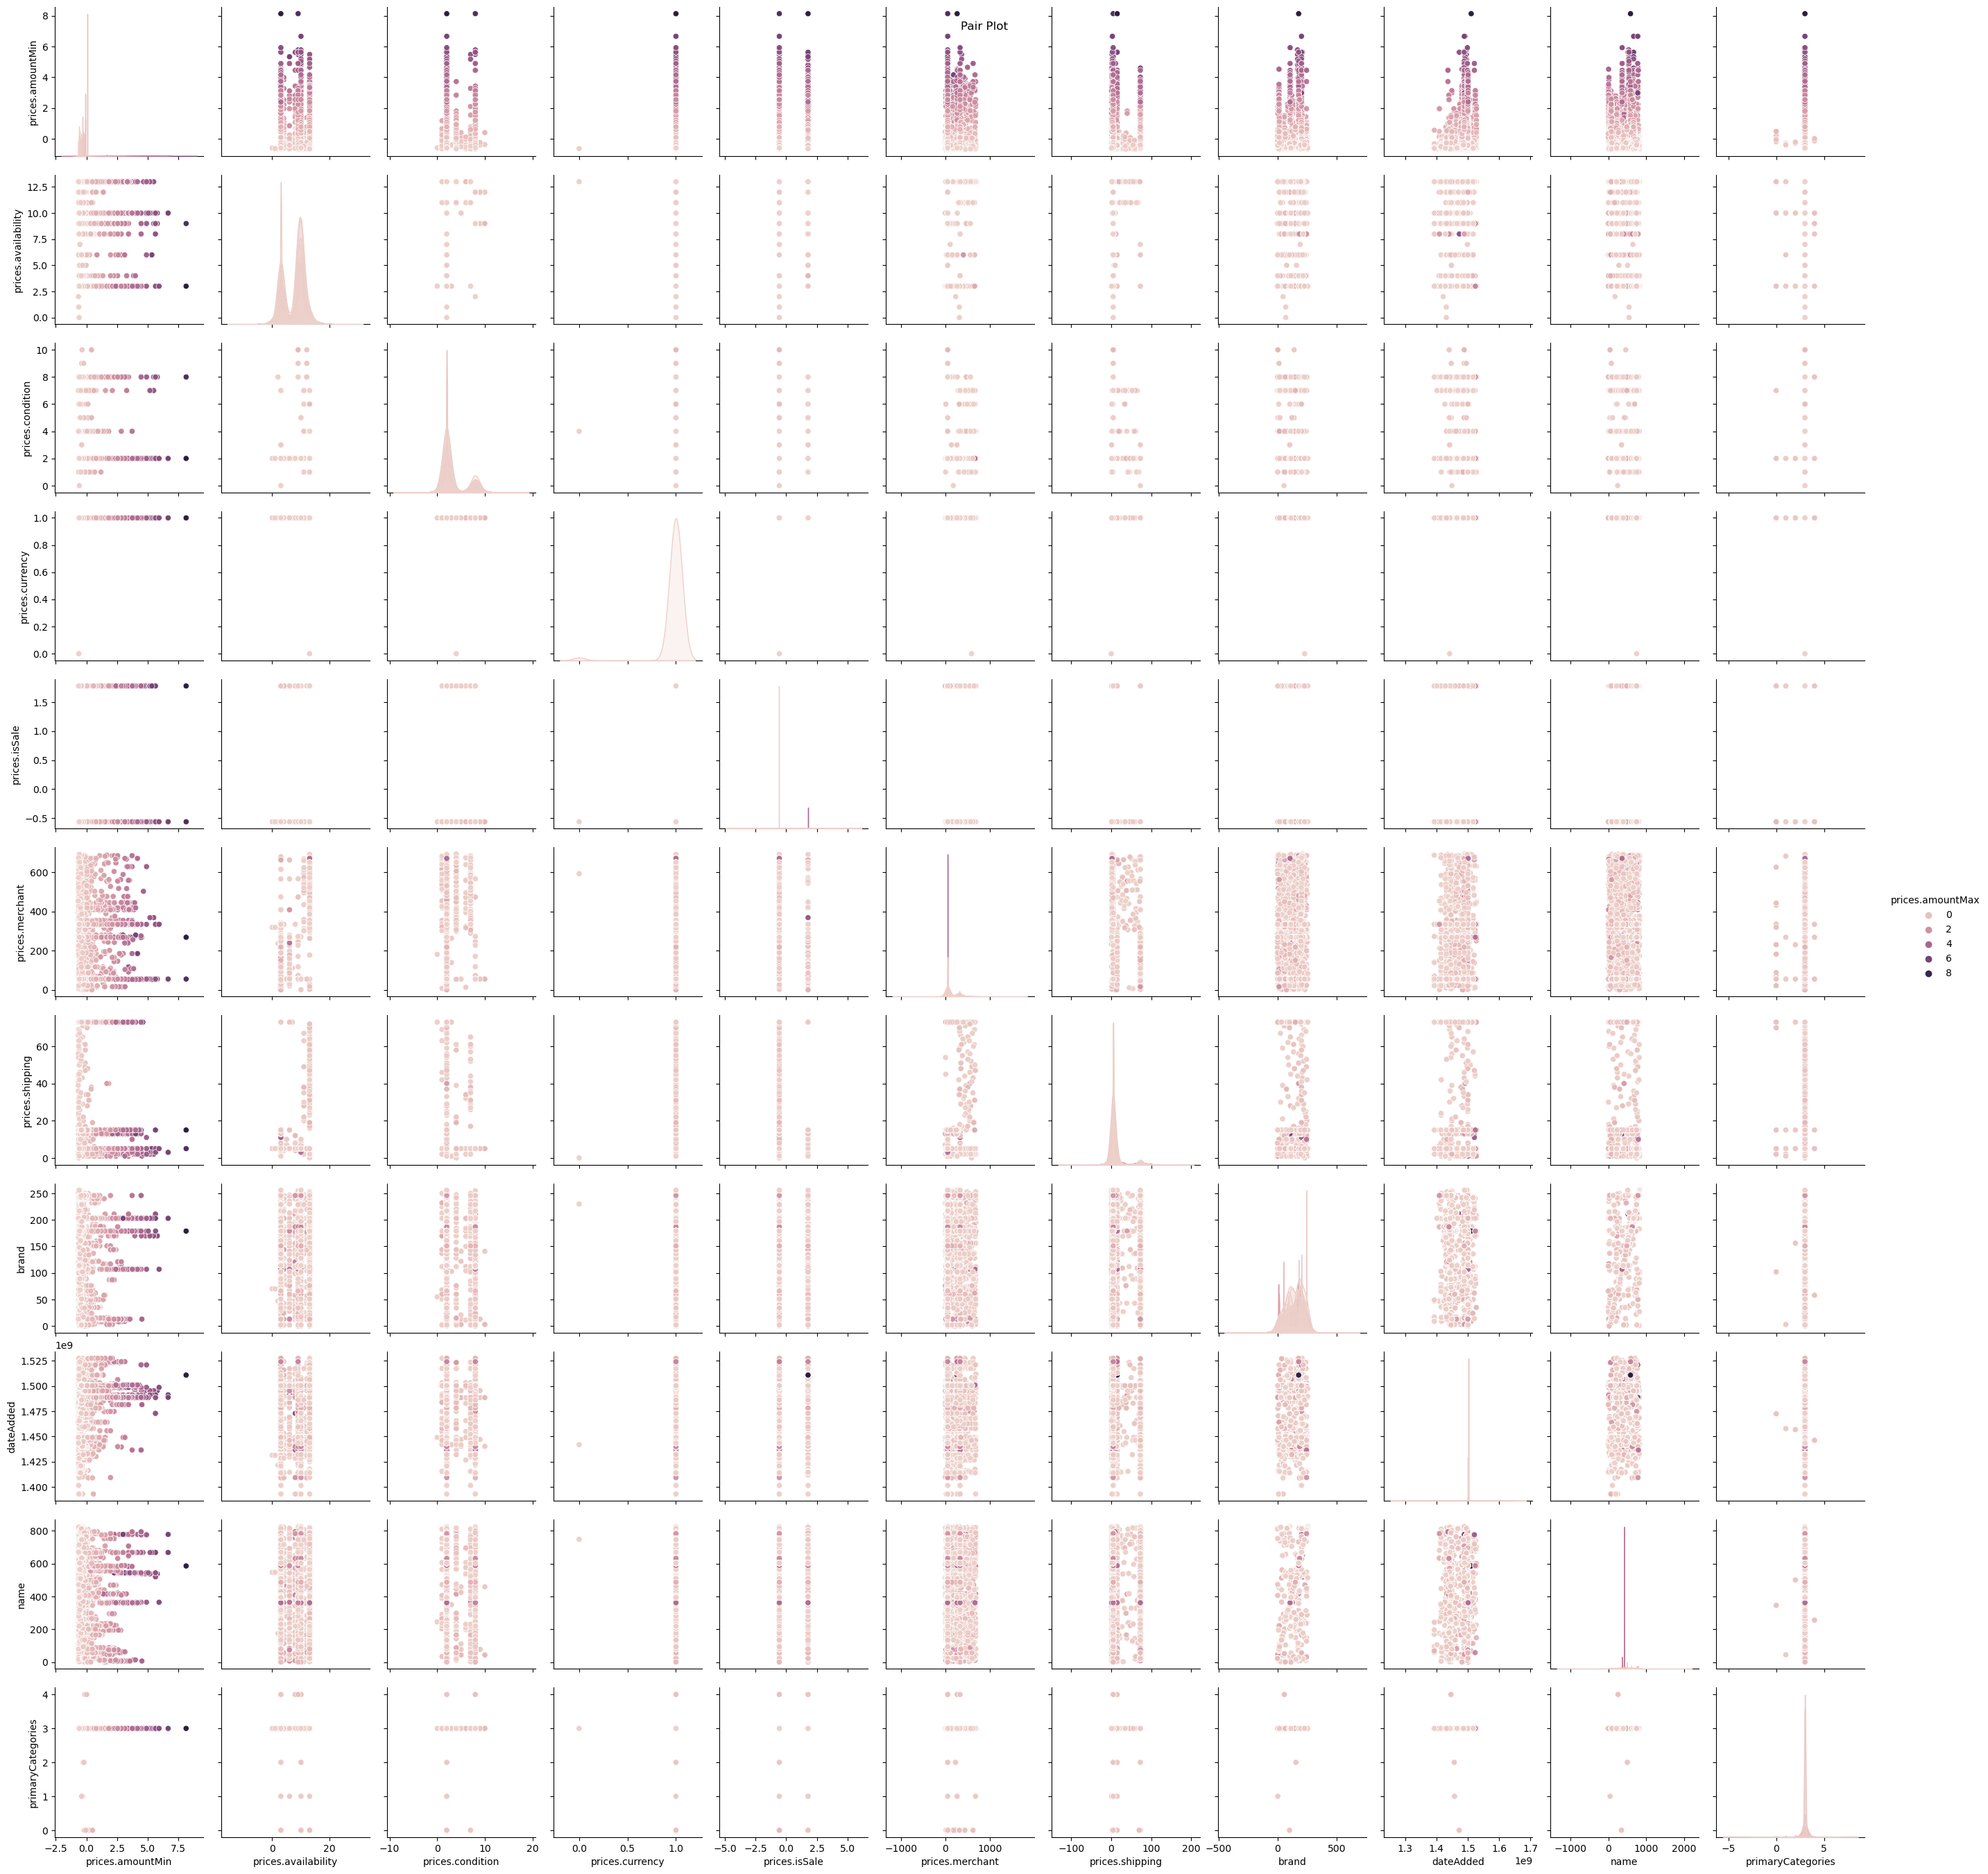

In [5]:
# Pair plot
sns.pairplot(cleaned_data, hue='prices.amountMax')
plt.suptitle('Pair Plot')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

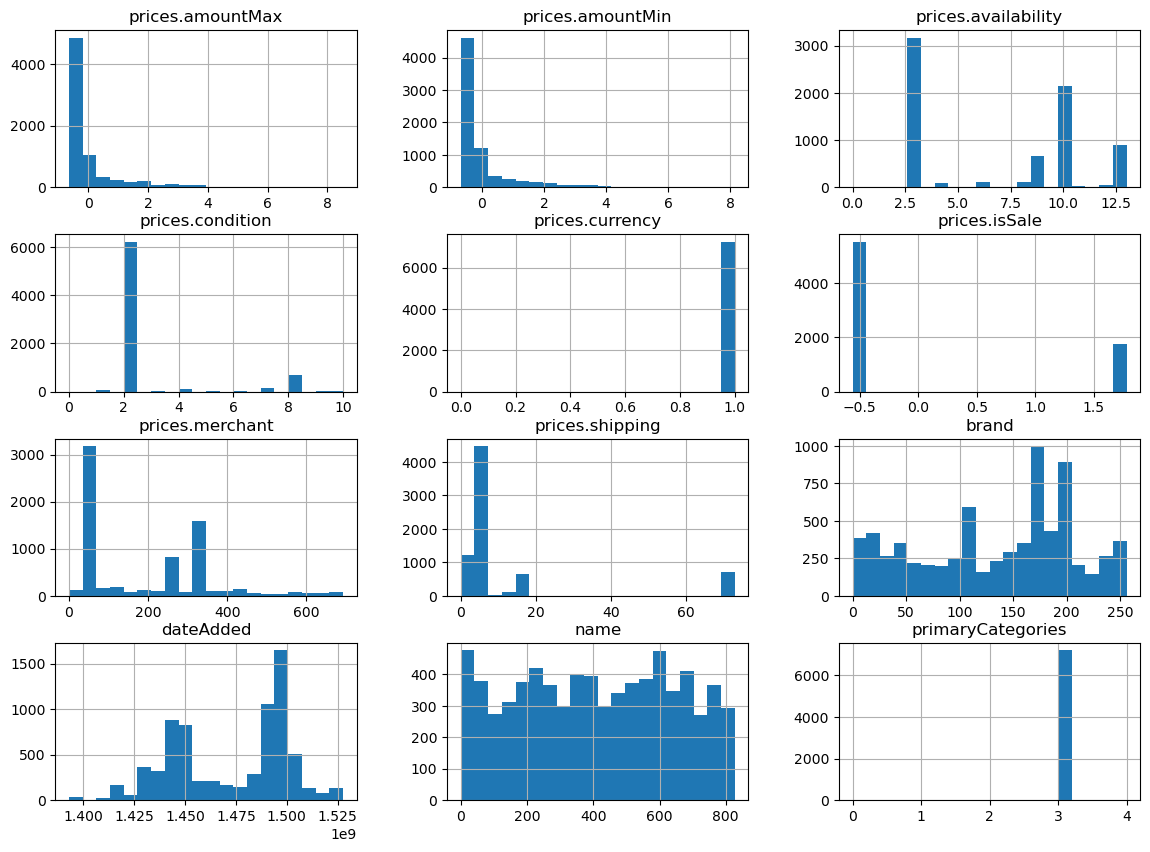

In [6]:
# Histograms
cleaned_data.hist(bins=20, figsize=(14, 10))
plt.show

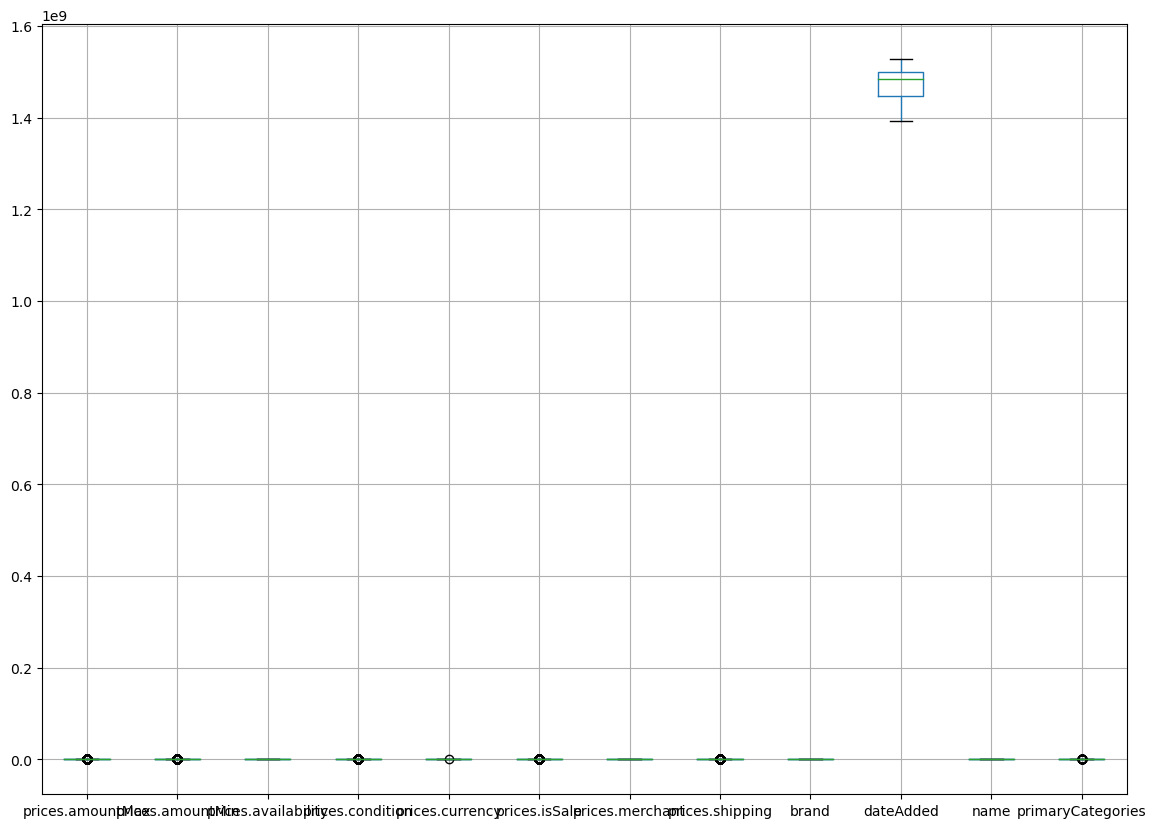

In [7]:
# Box plot
cleaned_data.boxplot(figsize=(14, 10))
plt.show()

In [8]:
#sorting data to find the sources from which customers buy most of the item.
cleaned_data.groupby('prices.merchant').size().sort_values(ascending=False)

prices.merchant
55     2806
334    1509
268     664
53      201
21       63
       ... 
325       1
324       1
323       1
322       1
692       1
Length: 693, dtype: int64

In [9]:
x = cleaned_data.drop(['prices.amountMax'], axis=1)
y = cleaned_data[['prices.amountMax']]
print('x:\n',x)
print('\ny:\n',y)

# spliting into 80:20 ration  
x_tr, x_tes, y_tr, y_tes = train_test_split(x, y, test_size = 0.2, random_state = 20)  
# describes information about train and test set  
print("\nx train dataset: ", x_tr.shape)  
print("y train dataset: ", y_tr.shape)  
print("x test dataset: ", x_tes.shape)  
print("y test dataset: ", y_tes.shape) 

x:
       prices.amountMin  prices.availability  prices.condition  \
0            -0.527546                   10                 2   
1            -0.586330                    3                 2   
2            -0.580437                    3                 2   
3            -0.578982                   10                 2   
4            -0.583391                   10                 2   
...                ...                  ...               ...   
7244         -0.564286                   10                 2   
7245         -0.580805                    3                 2   
7246         -0.577513                   10                 2   
7247         -0.576043                   10                 2   
7248         -0.582245                    3                 2   

      prices.currency  prices.isSale  prices.merchant  prices.shipping  brand  \
0                   1      -0.562215               55                5    182   
1                   1       1.778679              268

Text(0.5, 1.0, 'Correlation heatmap')

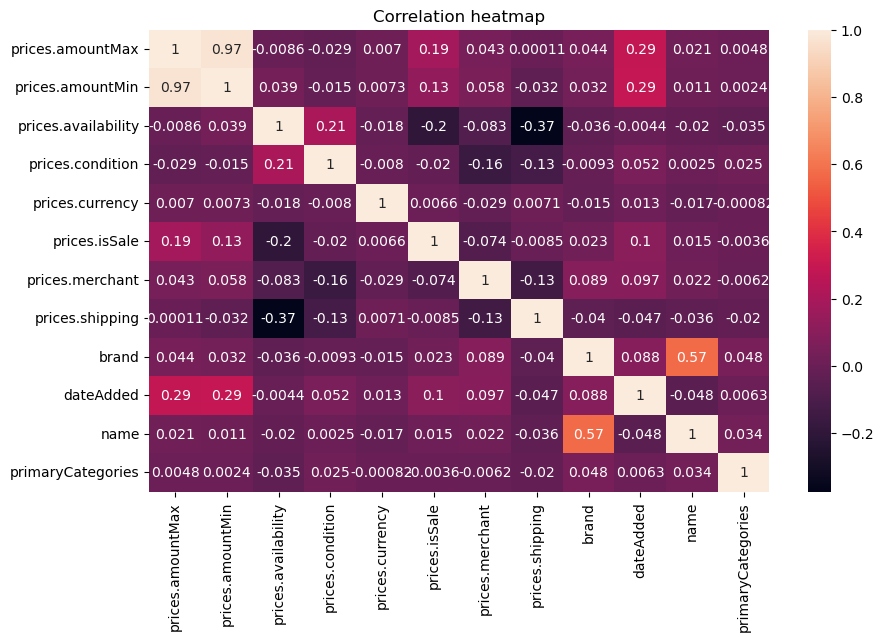

In [10]:
#Correlation matrix
plt.figure(figsize=(10, 6))
corr = cleaned_data.corr()
sns.heatmap(data=corr, annot=True)
plt.title('Correlation heatmap')  

# Regression models

# Linear Regression

In [11]:
regressor = LinearRegression()
regressor.fit(x_tr, y_tr)
y_pred = regressor.predict(x_tes)
meanAbErr = mean_absolute_error(y_tes, y_pred)
meanSqErr = mean_squared_error(y_tes, y_pred)
rootMeanSqErr = np.sqrt(mean_squared_error(y_tes, y_pred))
r2_lr = r2_score(y_tes, y_pred)
print('\n Linear Regression \n')
print(f'Coefficients: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')
print('\nTesting metrics:')
print('R squared:', r2_lr)
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

y_tr_pred = regressor.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mse_tr)
r2_tr = r2_score(y_tr, y_tr_pred)
print('\nTraining metrics:')
print('R squared:',r2_tr)
print('Mean Absolute Error:', mae_tr)
print('Mean Square Error:', mse_tr)
print('Root Mean Square Error:', rmse_tr)


 Linear Regression 

Coefficients: [[ 9.61169940e-01 -6.46161199e-03 -3.75731794e-03 -1.02241776e-01
   5.72188620e-02 -6.30625559e-05  1.07592257e-03  1.19823211e-04
   1.26205557e-10  2.04172826e-05  1.13804243e-02]]
Intercept: [-0.08815481]

Testing metrics:
R squared: 0.9425811863114725
Mean Absolute Error: 0.09923650638103253
Mean Square Error: 0.05745797309797273
Root Mean Square Error: 0.2397039279986307

Training metrics:
R squared: 0.9489602650663519
Mean Absolute Error: 0.0946499216244439
Mean Square Error: 0.051030107244198916
Root Mean Square Error: 0.22589844453691776


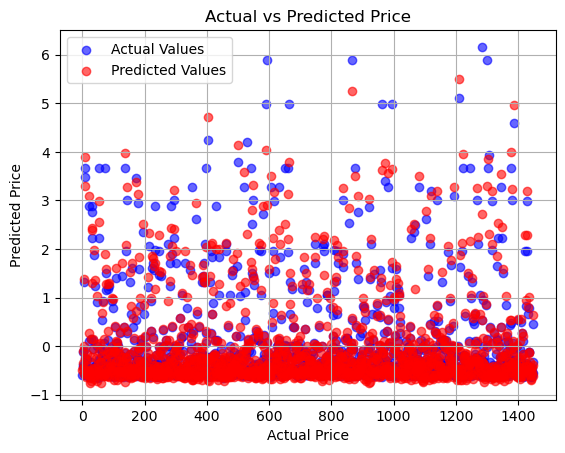

In [12]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

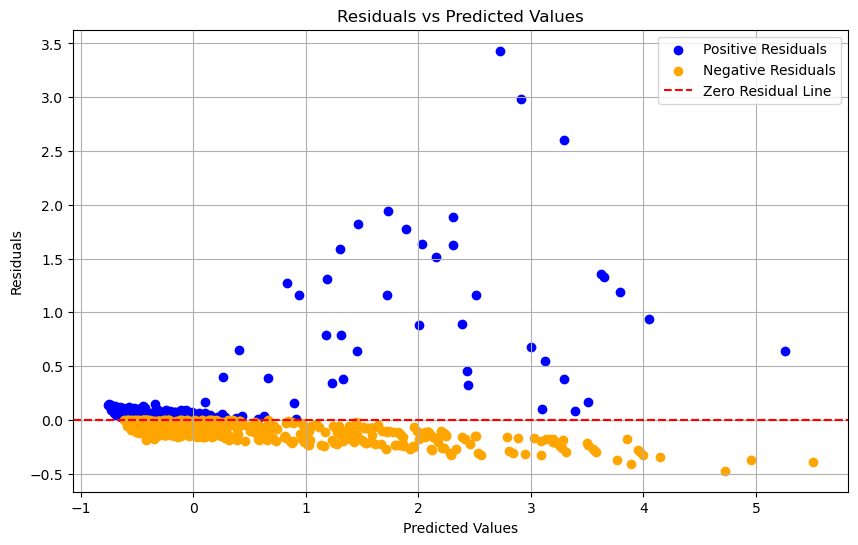

In [13]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

# Polynomial Regression

In [14]:
pr = PolynomialFeatures(degree = 2, interaction_only=True)
x_poly = pr.fit_transform(x_tes)
x_tr_poly = pr.fit_transform(x_tr)
lr = LinearRegression()
lr.fit(x_tr_poly, y_tr)
y_pred_poly = lr.predict(x_poly)
meanAbErr = mean_absolute_error(y_tes, y_pred_poly)
meanSqErr = mean_squared_error(y_tes, y_pred_poly)
rootMeanSqErr = np.sqrt(mean_squared_error(y_tes, y_pred_poly))
r2_pr = r2_score(y_tes, y_pred_poly)
print('\n Polynomial Regression \n')
print(f'Coefficients: {lr.coef_}')
print(f'Intercept: {lr.intercept_}')
print('\nTesting metrics:')
print('R squared:', r2_pr)
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

y_tr_pred = lr.predict(x_tr_poly)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mse_tr)
print('\nTraining metrics:')
print('R squared:',r2_score(y_tr, y_tr_pred))
print('Mean Absolute Error:', mae_tr)
print('Mean Square Error:', mse_tr)
print('Root Mean Square Error:', rmse_tr)


 Polynomial Regression 

Coefficients: [[-1.11793910e-05  6.70155089e-01 -7.27933793e-03 -2.29162109e-02
   9.61377611e-05  9.93612146e-02 -5.72715980e-04  1.92789846e-04
   2.94514624e-03 -3.85842557e-09 -8.81340666e-04 -4.91434023e-01
  -7.01514449e-03 -6.53712924e-03  6.71127984e-01  6.82525935e-02
  -1.13366423e-05  1.38495877e-03  2.13330149e-04 -2.56902567e-10
   4.51894642e-05 -3.54826971e-03 -1.32915435e-04 -7.56397549e-03
  -1.80799234e-02  4.77019016e-05 -1.21174538e-04 -1.15245478e-06
  -1.39973016e-12 -1.35139445e-06 -2.30120356e-03 -2.27001166e-02
  -3.48245274e-03  3.78305485e-06 -2.28216065e-04 -3.21651513e-06
   3.12065564e-11 -2.13754987e-06 -2.31987628e-04  9.93596723e-02
  -5.66034087e-04  1.92053015e-04  2.94558910e-03  1.72548048e-09
  -8.81313679e-04 -4.91434043e-01 -3.07288880e-04  5.94379752e-04
   7.16037526e-05  9.00321484e-15  2.20894730e-05 -3.06767290e-03
   5.60821317e-06 -3.34563552e-08  2.44360088e-13  4.73375627e-08
   2.14314280e-05  3.19656888e-06 -1

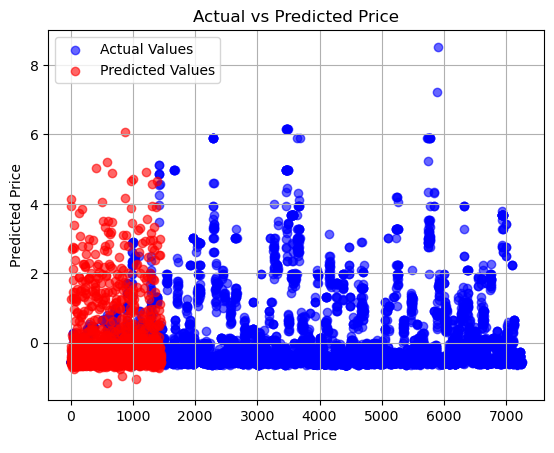

In [15]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y)), y, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred_poly)), y_pred_poly, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

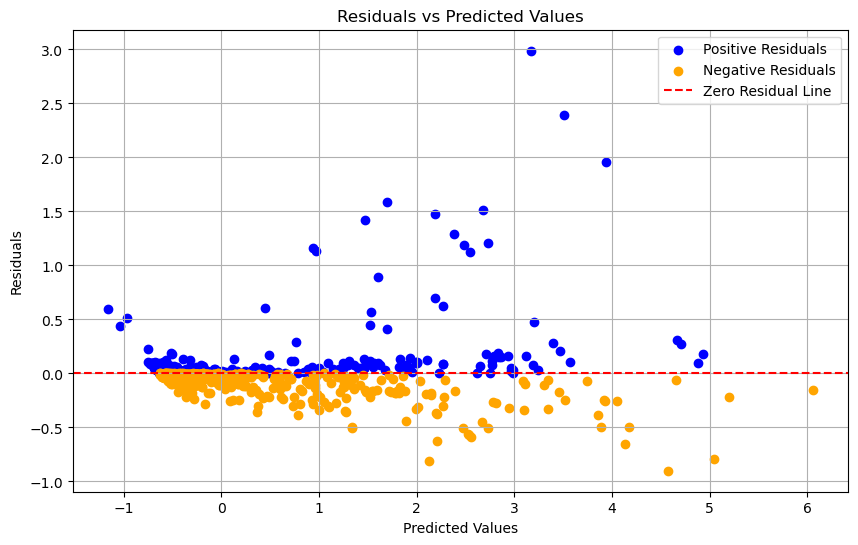

In [16]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred_poly = np.array(y_pred_poly).flatten()
residuals = y_tes - y_pred_poly

plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred_poly[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred_poly[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Support Vector Regression

In [17]:
svr = SVR()
svr.fit(x, y)
y_pred = svr.predict(x_tes)
mse = mean_squared_error(y_tes, y_pred)
mae = mean_absolute_error(y_tes, y_pred)
rmse = float(format(np.sqrt(mean_squared_error(y_tes, y_pred)), '.3f'))
r2_svr = r2_score(y_tes, y_pred)
print('Support Vector Regression \n')
print('Testing metrics')
print("RMSE: ", rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R-squared:', r2_svr)

y_tr_pred = svr.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = float(format(np.sqrt(mean_squared_error(y_tr, y_tr_pred)), '.3f'))
print('\nTraining metrics')
print("RMSE: ", rmse_tr)
print('Mean Squared Error:', mse_tr)
print('Mean Absolute Error:', mae_tr)
print('R-squared:',r2_score(y_tr, y_tr_pred))

Support Vector Regression 

Testing metrics
RMSE:  1.038
Mean Squared Error: 1.0772093734406751
Mean Absolute Error: 0.5221930899298258
R-squared: -0.07647522149207053

Training metrics
RMSE:  1.036
Mean Squared Error: 1.0736452916047972
Mean Absolute Error: 0.5166743514910097
R-squared: -0.07384785287704076


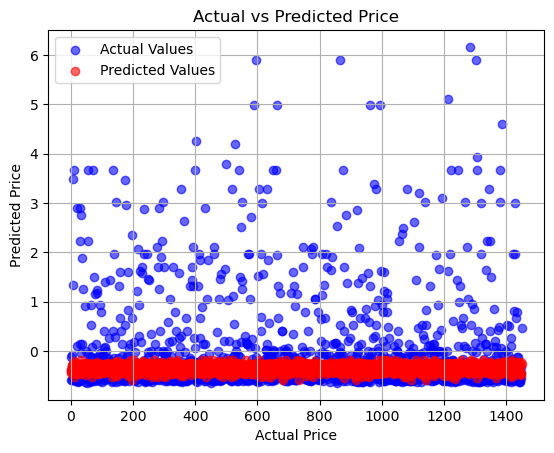

In [18]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

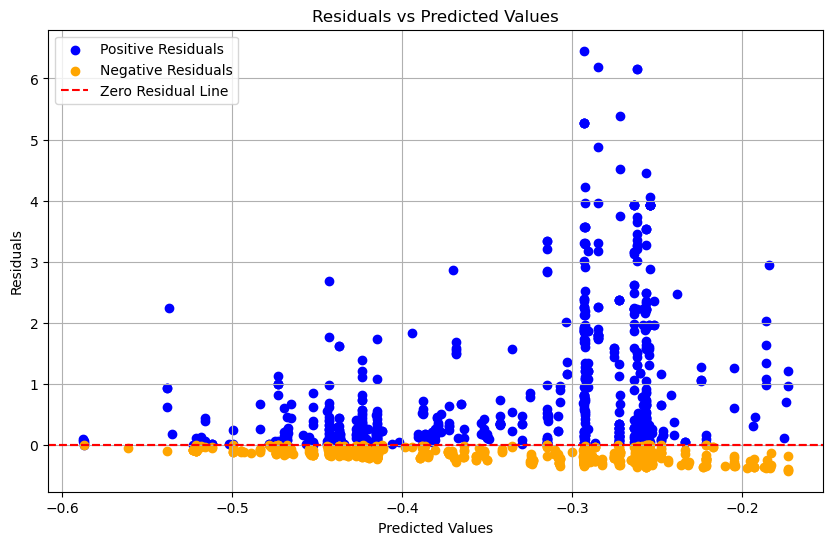

In [19]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

# Decision tree Regression

In [20]:
dtr = DecisionTreeRegressor(max_depth=3)    
dtr.fit(x, y) 
y_pred = dtr.predict(x_tes)
mse = mean_squared_error(y_tes, y_pred)
mae = mean_absolute_error(y_tes, y_pred)
rmse = float(format(np.sqrt(mean_squared_error(y_tes, y_pred)), '.3f'))
r2_dtr = r2_score(y_tes, y_pred)
print('Decision tree Regression \n')
print('Testing metrics')
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print('R squared:',r2_dtr)
print("RMSE: ", rmse)

y_tr_pred = dtr.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = float(format(np.sqrt(mean_squared_error(y_tr, y_tr_pred)), '.3f'))
print('\nTraining metrics')
print(f"Mean Squared Error: {mse_tr}")
print(f"Mean Absolute Error: {mae_tr}")
print('R squared:',r2_score(y_tr, y_tr_pred))
print("RMSE: ", rmse_tr)

Decision tree Regression 

Testing metrics
Mean Squared Error: 0.07138904119938355
Mean Absolute Error: 0.123652687101805
R squared: 0.9286596126695836
RMSE:  0.267

Training metrics
Mean Squared Error: 0.07446121039718645
Mean Absolute Error: 0.12483537232853224
R squared: 0.9255247412410047
RMSE:  0.273


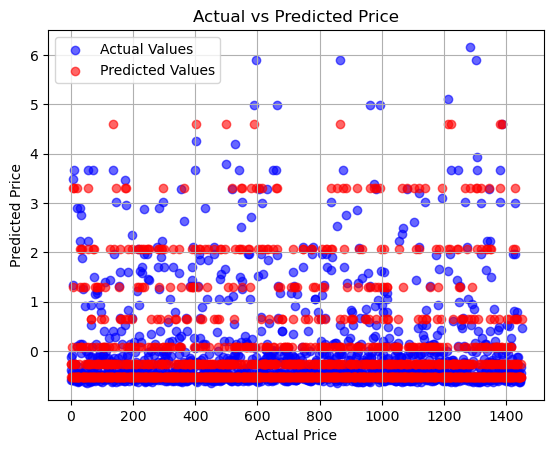

In [21]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

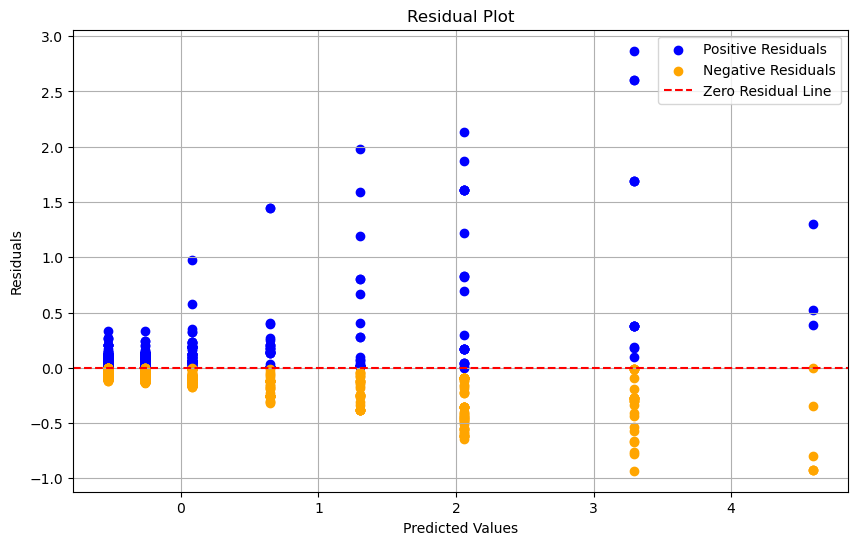

In [22]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Random Forest Regression

In [23]:
rfr = RandomForestRegressor(max_depth=3)
rfr.fit(x, y)
predictions = regressor.predict(x_tes)
mse = mean_squared_error(y_tes, predictions)
mae = mean_absolute_error(y_tes, predictions)
r2_rfr = r2_score(y_tes, predictions)
rmse = np.sqrt(mean_squared_error(y_tes, predictions))
print('Random Forest Regression \n')
print('Testing metrics')
print(f'Mean Squared Error: {mse}')
print(f"Mean Absolute Error: {mae:.2f}")
print('R-squared:',r2_rfr)
print("RMSE: ", rmse)

predictions_tr = regressor.predict(x_tr)
mse_tr = mean_squared_error(y_tr, predictions_tr)
mae_tr = mean_absolute_error(y_tr, predictions_tr)
r2_tr = r2_score(y_tr, predictions_tr)
rmse_tr = np.sqrt(mean_squared_error(y_tr, predictions_tr))
print('\nTraining metrics')
print(f'Mean Squared Error: {mse_tr}')
print(f"Mean Absolute Error: {mae_tr}")
print('R-squared:',r2_tr)
print("RMSE: ", rmse_tr)

Random Forest Regression 

Testing metrics
Mean Squared Error: 0.05745797309797273
Mean Absolute Error: 0.10
R-squared: 0.9425811863114725
RMSE:  0.2397039279986307

Training metrics
Mean Squared Error: 0.051030107244198916
Mean Absolute Error: 0.0946499216244439
R-squared: 0.9489602650663519
RMSE:  0.22589844453691776


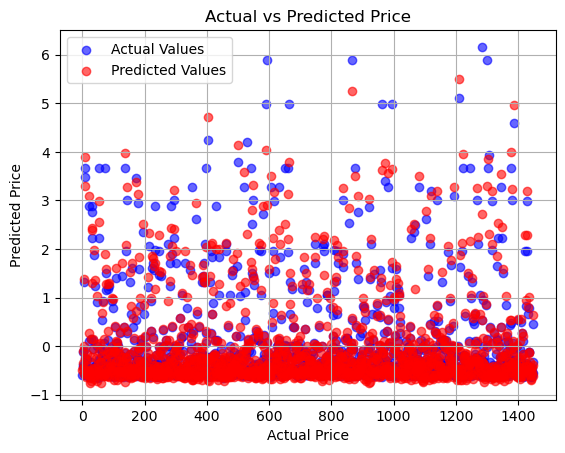

In [24]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

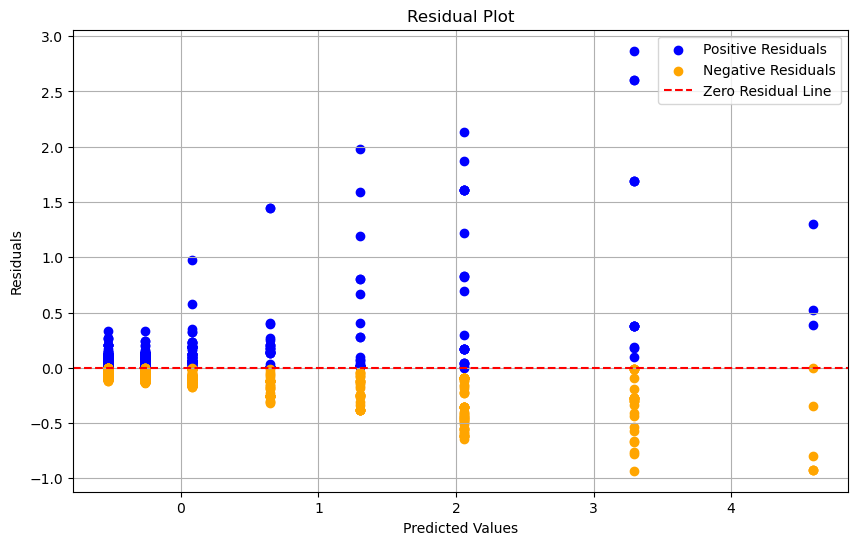

In [25]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Bayesian Regression

In [26]:
br = BayesianRidge() 
br.fit(x, y)
y_pred = br.predict(x_tes)
mse_test = mean_squared_error(y_tes, y_pred)
mae_test = mean_absolute_error(y_tes, y_pred)
rmse = np.sqrt(mean_squared_error(y_tes, y_pred))
r2_br = r2_score(y_tes, y_pred)
print('Bayesian Regression \n')
print("Coefficients: ", br.coef_)
print("Intercept: ", br.intercept_)
print('\nTesting metrics')
print('Mean Squared Error:', mse_test)
print('Mean Absolute Error:', mae_test)
print("RMSE: ", rmse)
print('R-squared:',r2_br)

y_tr_pred = br.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
print('\nTraining metrics')
print('Mean Squared Error:', mse_tr)
print('Mean Absolute Error:', mae_tr)
print("RMSE: ", rmse_tr)
print('R-squared:',r2_score(y_tr, y_tr_pred))

Bayesian Regression 

Coefficients:  [ 9.63931601e-01 -6.64979737e-03 -3.85204651e-03 -6.55484586e-02
  5.79299245e-02 -6.85189824e-05  9.96207190e-04  1.19427416e-04
  1.22050164e-10  2.44051903e-05  8.02400516e-03]
Intercept:  -0.10574302774670853

Testing metrics
Mean Squared Error: 0.05733563346132171
Mean Absolute Error: 0.10006065341684446
RMSE:  0.2394486029638129
R-squared: 0.9427034425698269

Training metrics
Mean Squared Error: 0.051043714628357176
Mean Absolute Error: 0.09567027392565322
RMSE:  0.22592856089560076
R-squared: 0.9489466551149314


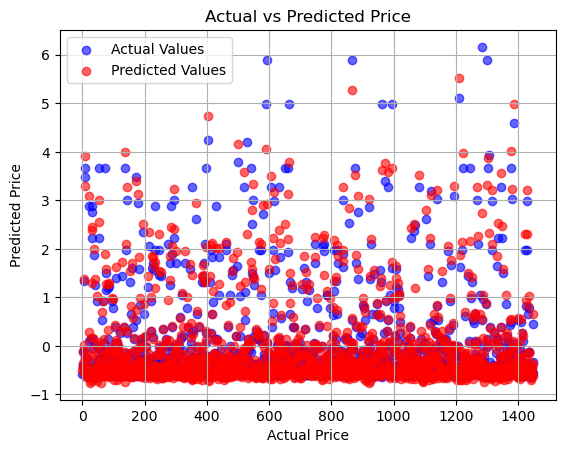

In [27]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

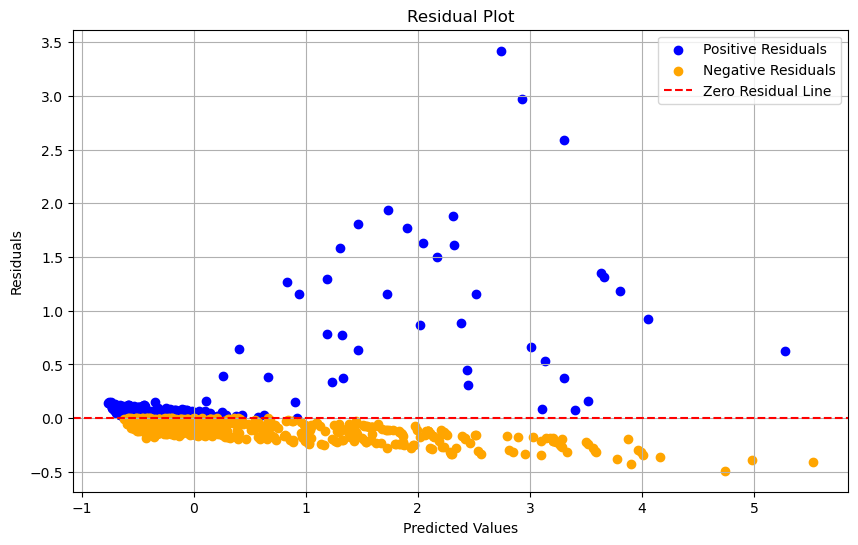

In [28]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Gaussian Regression

In [29]:
gpr = GaussianProcessRegressor()
gpr.fit(x_tr, y_tr)
y_pred = gpr.predict(x_tes)
mse = mean_squared_error(y_tes, y_pred)
r2_gr = r2_score(y_tes, y_pred)
mae = mean_absolute_error(y_tes, y_pred)
rmse = np.sqrt(mean_squared_error(y_tes, y_pred))
print('Gaussian Regression \n')
print('Testing metrics')
print(f"MSE: {mse}")
print('R squared:',r2_gr)
print(f"MAE: {mae}")
print("RMSE: ", rmse)

y_tr_pred = gpr.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
r2_tr = r2_score(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
print('\nTraining metrics')
print(f"MSE: {mse_tr}")
print('R squared:',r2_score(y_tr, y_tr_pred))
print(f"MAE: {mae_tr}")
print("RMSE: ", rmse_tr)

Gaussian Regression 

Testing metrics
MSE: 0.32835904088526285
R squared: 0.6718647460921359
MAE: 0.2881139527629588
RMSE:  0.5730262130873794

Training metrics
MSE: 5.607027413390176e-07
R squared: 0.9999994391914726
MAE: 3.9330596579688344e-05
RMSE:  0.0007488008689491603


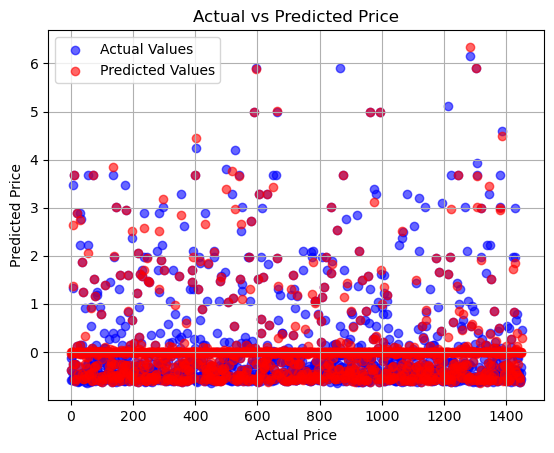

In [30]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

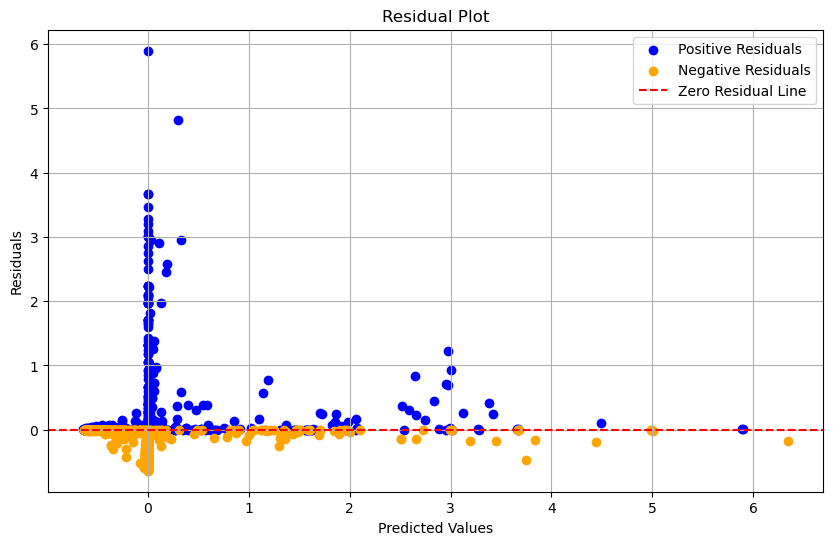

In [31]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Stepwise Regression

In [32]:
x_tr_const = sm.add_constant(x_tr)
x_tes_const = sm.add_constant(x_tes)

def stepwise_selection(x, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(x.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(x_tr, y_tr)

print('Selected features:')
print(result)

x_tr_selected = x_tr_const[result]
x_tes_selected = x_tes_const[result]

model = sm.OLS(y_tr, x_tr_selected).fit()
test_predictions = model.predict(x_tes_selected)
mse_test = mean_squared_error(y_tes, test_predictions)
mae_test = mean_absolute_error(y_tes, test_predictions)
rmse_test = np.sqrt(mse_test)
r2_step = r2_score(y_tes, test_predictions)

print('Stepwise Regression \n')
print('Coefficients:\n', model.params)
print('Intercept:', model.params[0])
print('\nTesting metrics:')
print('R squared:',r2_step)
print('Mean Absolute Error:',mae_test)
print('Mean Square Error:',mse_test)
print('Root Mean Square Error:',rmse_test)

tr_predictions = model.predict(x_tr_selected)
mse_tr = mean_squared_error(y_tr, tr_predictions)
mae_tr = mean_absolute_error(y_tr, tr_predictions)
rmse_tr = np.sqrt(mse_tr)
r2_tr = model.rsquared
print('\nTraining metrics:')
print(f'R squared: {r2_tr}')
print(f'Mean Absolute Error: {mae_tr}')
print(f'Mean Square Error: {mse_tr}')
print(f'Root Mean Square Error: {rmse_tr}')

Add  prices.amountMin               with p-value 0.0
Add  prices.isSale                  with p-value 1.64877e-93
Add  prices.availability            with p-value 1.44004e-28
Add  prices.shipping                with p-value 4.33917e-13
Add  brand                          with p-value 0.000171561
Add  prices.merchant                with p-value 0.00379683
Selected features:
['prices.amountMin', 'prices.isSale', 'prices.availability', 'prices.shipping', 'brand', 'prices.merchant']
Stepwise Regression 

Coefficients:
 prices.amountMin       0.961647
prices.isSale          0.058574
prices.availability   -0.005501
prices.shipping        0.001258
brand                  0.000207
prices.merchant       -0.000037
dtype: float64
Intercept: 0.9616474685002842

Testing metrics:
R squared: 0.9423895304200922
Mean Absolute Error: 0.09929643063973051
Mean Square Error: 0.0576497596979316
Root Mean Square Error: 0.24010364365817444

Training metrics:
R squared: 0.9488475743438897
Mean Absolute Error: 0

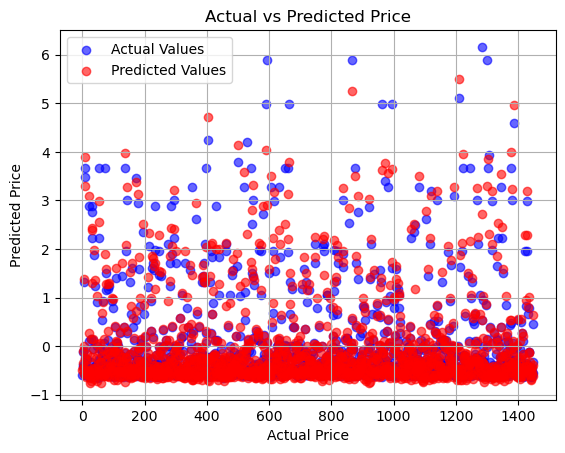

In [33]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

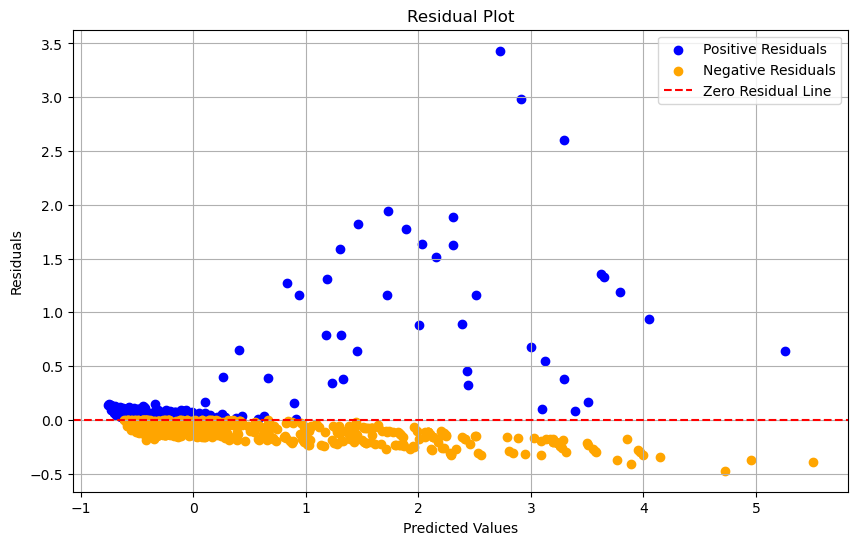

In [34]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
predictions = np.array(predictions).flatten()
residuals = y_tes - predictions
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(predictions[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(predictions[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# ElasticNet Regression

In [35]:
elastic_net = ElasticNet(alpha=0.02, l1_ratio=0.5, max_iter=10000, random_state=20)
elastic_net.fit(x_tr, y_tr)
y_pred = elastic_net.predict(x_tes)
mse = mean_squared_error(y_tes, y_pred)
mae = mean_absolute_error(y_tes, y_pred)
rmse = np.sqrt(mean_squared_error(y_tes, y_pred))
r2_en = r2_score(y_tes, y_pred)
print('ElasticNet Regression \n')
print('Testing metrics')
print(f"MSE: {mse}")
print('R squared:',r2_en)
print(f"MAE: {mae}")
print("RMSE: ", rmse)

y_tr_pred = elastic_net.predict(x_tr)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
print('\nTraining metrics')
print(f"MSE: {mse_tr}")
print('R squared:',r2_score(y_tr, y_tr_pred))
print(f"MAE: {mae_tr}")
print("RMSE: ", rmse_tr)

ElasticNet Regression 

Testing metrics
MSE: 0.05860118145030851
R squared: 0.9414387570914579
MAE: 0.09075957116123612
RMSE:  0.2420768089890242

Training metrics
MSE: 0.05154139879178564
R squared: 0.9484488770550009
MAE: 0.0860587850619858
RMSE:  0.22702730847143837


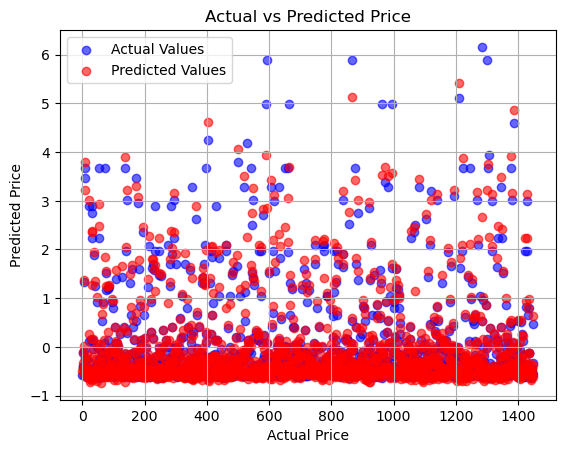

In [36]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

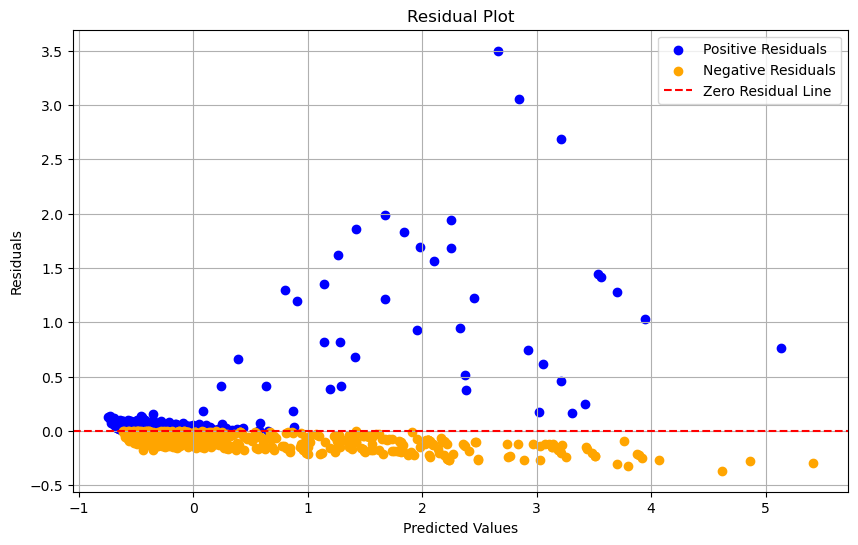

In [37]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# MLP

In [38]:
mlp_model = MLPRegressor(hidden_layer_sizes=(150,100,50),
                       max_iter = 10,activation = 'tanh',
                        random_state=42, verbose=True)
mlp_model.fit(x_tr, y_tr)
y_pred = mlp_model.predict(x_tes) 
mae = mean_absolute_error(y_tes, y_pred)
rmse = np.sqrt(mean_squared_error(y_tes, y_pred))
r2_mlp = r2_score(y_tes, y_pred)
print('MLP \n')
print('Testing metrics')
print(f"Mean Absolute Error: {mae}")
print('R squared:',r2_mlp)
print(f"RMSE: {rmse}")
print("Mean Squared Error:", mean_squared_error(y_tes, y_pred))  

y_tr_pred = mlp_model.predict(x_tr) 
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
print('\nTraining metrics')
print(f"Mean Absolute Error: {mae_tr}")
print('R squared:',r2_score(y_tr, y_tr_pred))
print(f"RMSE: {rmse_tr}")
print("Mean Squared Error:", mean_squared_error(y_tr, y_tr_pred))  

Iteration 1, loss = 0.52141592
Iteration 2, loss = 0.50384054
Iteration 3, loss = 0.50071853
Iteration 4, loss = 0.50293469
Iteration 5, loss = 0.50441271
Iteration 6, loss = 0.50172972
Iteration 7, loss = 0.50331131
Iteration 8, loss = 0.50143705
Iteration 9, loss = 0.50104992
Iteration 10, loss = 0.50206593
MLP 

Testing metrics
Mean Absolute Error: 0.6325678392016358
R squared: -0.0023416312952537766
RMSE: 1.0015114699399659
Mean Squared Error: 1.0030252244213111

Training metrics
Mean Absolute Error: 0.6251699202471312
R squared: -0.0015130028935996798
RMSE: 1.000661824112004
Mean Squared Error: 1.0013240862351631


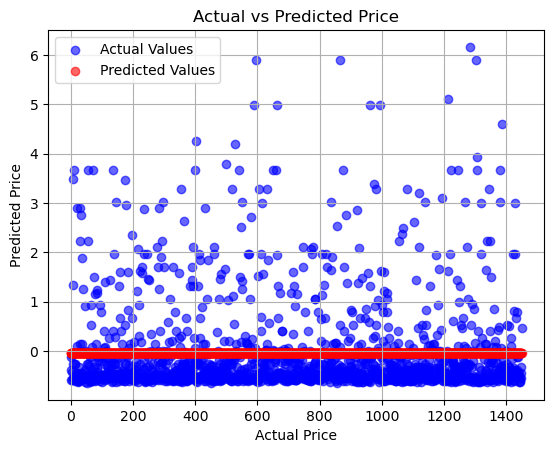

In [39]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

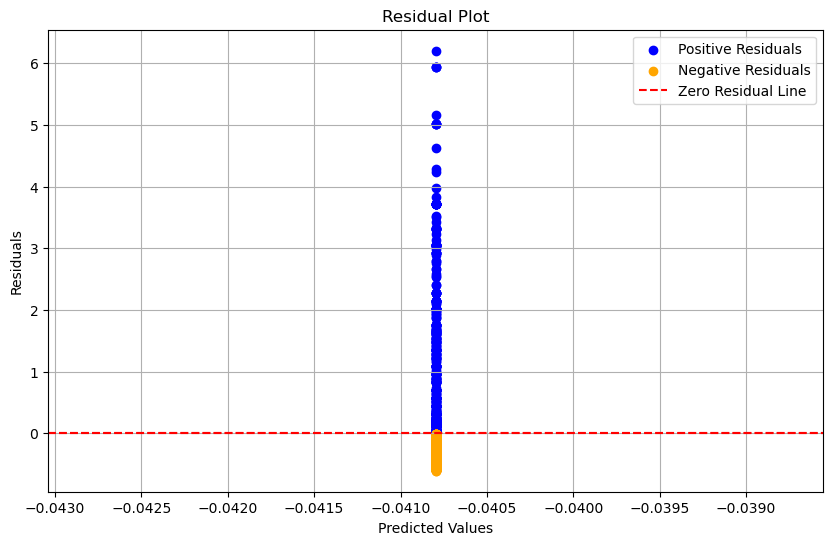

In [40]:
#Plot Residual Plot
y_tes = np.array(y_tes).flatten()
y_pred = np.array(y_pred).flatten()
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

# RBF Regression

In [41]:
# Fit SVR with RBF kernel
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(x_tr, y_tr)
y_pred = svr_rbf.predict(x_tes)
mae = mean_absolute_error(y_tes, y_pred)
mse = mean_squared_error(y_tes, y_pred)
rmse = np.sqrt(mse)
r2_rbf = r2_score(y_tes, y_pred)
print('RBF Regression \n')
print('Testing metrics')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Square Error: {mse}')
print(f'Root Mean Square Error: {rmse}')
print(f'R squared: {r2_rbf}')

y_tr_pred = svr_rbf.predict(x_tr)
mae_tr = mean_absolute_error(y_tr, y_tr_pred)
mse_tr = mean_squared_error(y_tr, y_tr_pred)
rmse_tr = np.sqrt(mse_tr)
r2_tr = r2_score(y_tr, y_tr_pred)
print('\nTraining metrics')
print(f'Mean Absolute Error: {mae_tr}')
print(f'Mean Square Error: {mse_tr}')
print(f'Root Mean Square Error: {rmse_tr}')
print(f'R squared: {r2_tr}')

RBF Regression 

Testing metrics
Mean Absolute Error: 0.522446857944971
Mean Square Error: 1.080755001759692
Root Mean Square Error: 1.039593671469624
R squared: -0.08001843335426506

Training metrics
Mean Absolute Error: 0.516760421693265
Mean Square Error: 1.0769684296219157
Root Mean Square Error: 1.0377708945725523
R squared: -0.07717161786013205


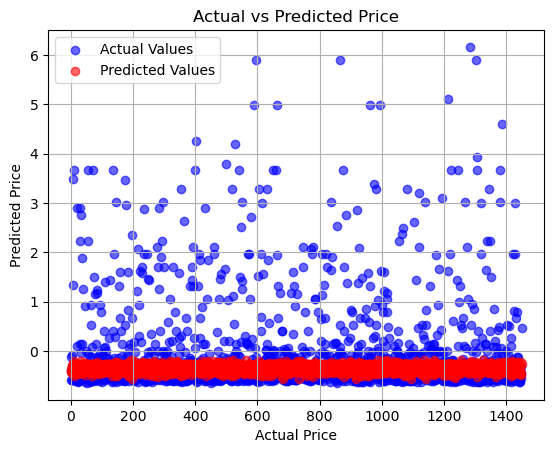

In [42]:
#Plot Predicted vs Actual Graph
plt.scatter(range(len(y_tes)), y_tes, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

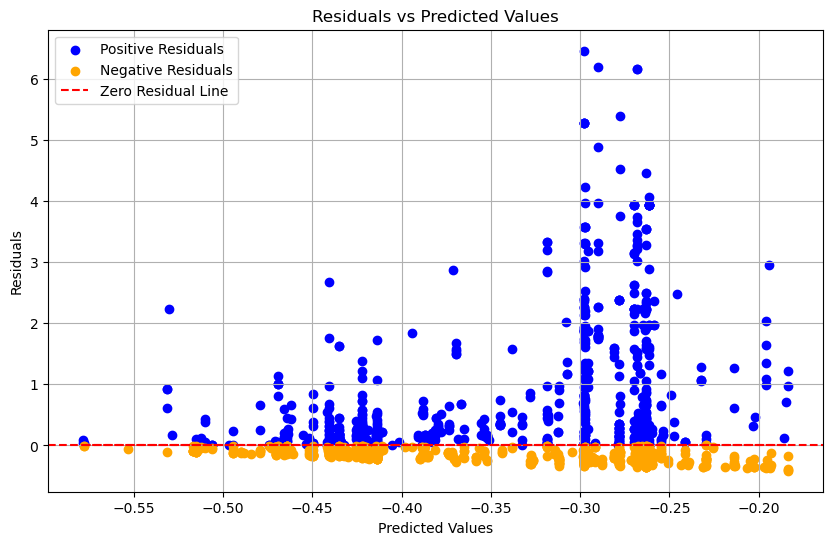

In [43]:
# Plot Residual Plot
residuals = y_tes - y_pred
plt.figure(figsize=(10, 6))
positive_residuals = residuals > 0
plt.scatter(y_pred[positive_residuals], residuals[positive_residuals], color='blue', label='Positive Residuals')
negative_residuals = residuals <= 0
plt.scatter(y_pred[negative_residuals], residuals[negative_residuals], color='orange', label='Negative Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Model Performance Comparisons

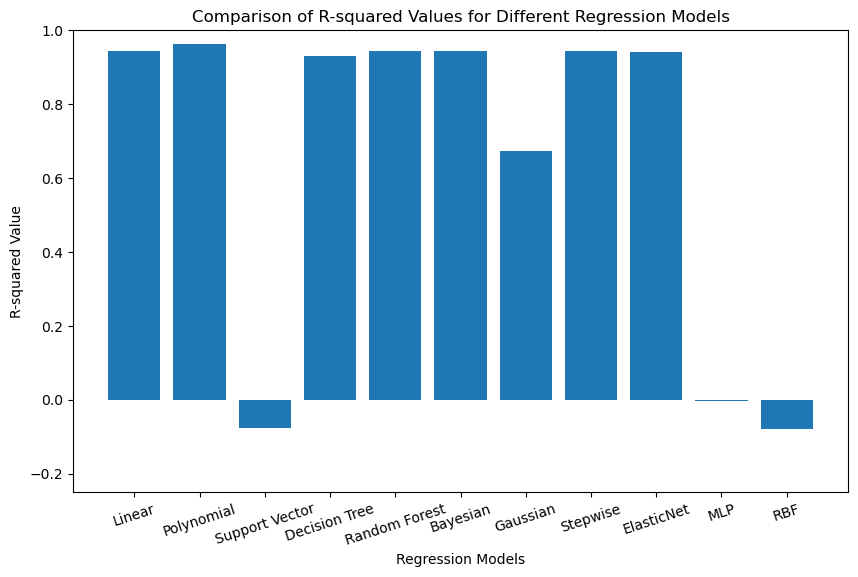

Linear: R squared = 0.94
Polynomial: R squared = 0.96
Support Vector: R squared = -0.08
Decision Tree: R squared = 0.93
Random Forest: R squared = 0.94
Bayesian: R squared = 0.94
Gaussian: R squared = 0.67
Stepwise: R squared = 0.94
ElasticNet: R squared = 0.94
MLP: R squared = -0.00
RBF: R squared = -0.08


In [44]:
# Plotting R-squared values
models = ['Linear', 'Polynomial', 'Support Vector', 'Decision Tree','Random Forest','Bayesian', 'Gaussian', 'Stepwise', 'ElasticNet', 'MLP','RBF']
r2_values = [r2_lr, r2_pr, r2_svr, r2_dtr, r2_rfr, r2_br, r2_gr, r2_step, r2_en, r2_mlp, r2_rbf]
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values)
plt.xlabel('Regression Models')
plt.ylabel('R-squared Value')
plt.title('Comparison of R-squared Values for Different Regression Models')
plt.ylim(-0.25, 1)
plt.xticks(rotation=18)
plt.show()
for model, r2 in zip(models, r2_values):
    print(f'{model}: R squared = {r2:.2f}')

# Cross Validation

# Linear Regression

In [45]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(regressor, x_tr, y_tr, cv=kf, scoring=mae_scorer)
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(regressor, x_tr, y_tr, cv=kf, scoring=mse_scorer)
cv_rmse = np.sqrt(cv_mse.mean())
cv_r2 = cross_val_score(regressor, x_tr, y_tr, cv=kf, scoring='r2')

print('Cross Validation - Linear Regression \n')
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
print('Cross-Validated R squared:', cv_r2.mean())

Cross Validation - Linear Regression 

Cross-Validated Mean Absolute Error: 0.0950745995733201
Cross-Validated Mean Squared Error: 0.05146663639172148
Cross-Validated Root Mean Squared Error: 0.22686259363703282
Cross-Validated R squared: 0.9489725917318792


# Polynomial Regression

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(lr, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(lr, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(lr, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.0950745995733201
Cross-Validated Mean Squared Error: 0.05146663639172148
Cross-Validated Root Mean Squared Error: 0.22686259363703282
Cross-Validated R squared: 0.9489725917318792


# Support Vector Regression

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(svr, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(svr, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(svr, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.5168323906844503
Cross-Validated Mean Squared Error: 1.0790426901730998
Cross-Validated Root Mean Squared Error: 1.0387697965252454
Cross-Validated R squared: -0.07903848953204622


# Decision tree Regression

In [48]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(dtr, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(dtr, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(dtr, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.12872622011171003
Cross-Validated Mean Squared Error: 0.08327414975379599
Cross-Validated Root Mean Squared Error: 0.2885726074210717
Cross-Validated R squared: 0.9173191896282628


# Random Forest Regression

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(rfr, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(rfr, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(rfr, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.09892882788478134
Cross-Validated Mean Squared Error: 0.06117194641913112
Cross-Validated Root Mean Squared Error: 0.24732963109811795
Cross-Validated R squared: 0.9394639238137108


# Bayesian Regression

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(br, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(br, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(br, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.09503381231941975
Cross-Validated Mean Squared Error: 0.05146647428299096
Cross-Validated Root Mean Squared Error: 0.22686223635279398
Cross-Validated R squared: 0.9489729524676263


# Gausian Regression

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(gpr, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(gpr, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(gpr, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.31728720634365914
Cross-Validated Mean Squared Error: 0.4212080087292883
Cross-Validated Root Mean Squared Error: 0.649005399614894
Cross-Validated R squared: 0.5790126419045644


# Stepwise Regression

In [52]:
class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None
    
    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit()
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return r2_score(y, predictions)

ols_wrapper = StatsmodelsOLS()
y_pred_cv = cross_val_predict(ols_wrapper, x_tr_selected, y_tr, cv=5)
cv_scores = cross_val_score(ols_wrapper, x_tr_selected, y_tr, cv=5)
mse_cv = mean_squared_error(y_tr, y_pred_cv)
mae_cv = mean_absolute_error(y_tr, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)

print('Cross-Validation Mean Absolute Error: {:.2f}'.format(mae_cv))
print('Cross-Validation Mean Square Error: {:.2f}'.format(mse_cv))
print('Cross-Validation Root Mean Square Error: {:.2f}'.format(rmse_cv))
print('Cross-Validation R-squared: {:.2f}'.format(np.mean(cv_scores)))

Cross-Validation Mean Absolute Error: 0.09
Cross-Validation Mean Square Error: 0.05
Cross-Validation Root Mean Square Error: 0.23
Cross-Validation R-squared: 0.95


# ElasticNet Regression

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(elastic_net, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(elastic_net, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(elastic_net, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.08646880649220716
Cross-Validated Mean Squared Error: 0.051976021215713764
Cross-Validated Root Mean Squared Error: 0.22798250199459116
Cross-Validated R squared: 0.9485173357924944


# MLP Regression

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(mlp_model, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(mlp_model, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(mlp_model, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Iteration 1, loss = 0.52680904
Iteration 2, loss = 0.50938501
Iteration 3, loss = 0.51057672
Iteration 4, loss = 0.51069208
Iteration 5, loss = 0.50556122
Iteration 6, loss = 0.50565293
Iteration 7, loss = 0.50347973
Iteration 8, loss = 0.50391284
Iteration 9, loss = 0.50417111
Iteration 10, loss = 0.50496456
Iteration 1, loss = 0.55706493
Iteration 2, loss = 0.52752042
Iteration 3, loss = 0.52193897
Iteration 4, loss = 0.52139417
Iteration 5, loss = 0.52123181
Iteration 6, loss = 0.52219001
Iteration 7, loss = 0.52553963
Iteration 8, loss = 0.52949782
Iteration 9, loss = 0.52106757
Iteration 10, loss = 0.52364607
Iteration 1, loss = 0.53655199
Iteration 2, loss = 0.50655577
Iteration 3, loss = 0.51232628
Iteration 4, loss = 0.50656033
Iteration 5, loss = 0.50966423
Iteration 6, loss = 0.51247731
Iteration 7, loss = 0.50612656
Iteration 8, loss = 0.50686106
Iteration 9, loss = 0.50550016
Iteration 10, loss = 0.51035046
Iteration 1, loss = 0.52314171
Iteration 2, loss = 0.48748122
Itera

# RBF Regression

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(svr_rbf, x_tr, y_tr, cv=kf, scoring=mae_scorer)
print('Cross-Validated Mean Absolute Error:', cv_mae.mean())
mse_scorer = make_scorer(mean_squared_error)
cv_mse = cross_val_score(svr_rbf, x_tr, y_tr, cv=kf, scoring=mse_scorer)
print('Cross-Validated Mean Squared Error:', cv_mse.mean())
cv_rmse = np.sqrt(cv_mse.mean())
print('Cross-Validated Root Mean Squared Error:', cv_rmse)
cv_r2 = cross_val_score(svr_rbf, x_tr, y_tr, cv=kf, scoring='r2')
print('Cross-Validated R squared:', cv_r2.mean())

Cross-Validated Mean Absolute Error: 0.5168323906844503
Cross-Validated Mean Squared Error: 1.0790426901730998
Cross-Validated Root Mean Squared Error: 1.0387697965252454
Cross-Validated R squared: -0.07903848953204622
